In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import spotify
import utils

sp = spotify.login(scope='playlist-modify-private')
user = sp.current_user()
username = user['id']
displayName = user['display_name']
displayName



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=ca3831dc54e745ec9fd50425c059da48&response_type=code&redirect_uri=https%3A%2F%2Flocalhost%3A8080%2F&scope=playlist-modify-private in your browser




Enter the URL you were redirected to:  https://localhost:8080/?code=AQDFblmAkyfWglYWmVAOlI_uxr1Wmu4mxbzduiJDxi0-bbIU5b0hFUX6FlFDj9J_-9-LKpPFQDgCyPdif5l-Gq2YZQyGs6j2ATfYU_WSHARvJ-6VN6NjvY9lapFtdiUpPAPfv7ekj9hHg0WB-DSYJnW78WEqiz460AC9FKaXK9nt5fIMhKqcaMGQYpFP6ufHplyghkZYc6Fzo7mYz8bGYh25xn1GXQ


'Mehmet Birgi'

In [10]:
playlist_id = 'spotify:playlist:2CcP1BFKflMSc3AvGzwWfA'
playlist = sp.user_playlist(username, playlist_id, fields="name, tracks, next")
playlist_name = playlist['name']
playlist_name

'Run Test BPM 125 - 130 All Tracks'

In [11]:
tracks = []
audio_features = []
tracks_paging_object = playlist['tracks']
while True:
    track_id_list = []
    for item in tracks_paging_object['items']:
        track_result = item['track']
        track = {
            'id': track_result['id'],
            'name': track_result['name'],
            'artist_id': track_result['artists'][0]['id'],
            'artist_name': track_result['artists'][0]['name'],
            'popularity': track_result['popularity'],
        }
        tracks.append(track)
        track_id_list.append(track['id'])
    audio_features.extend(sp.audio_features(track_id_list))
    if not tracks_paging_object['next']:
        break
    tracks_paging_object = sp.next(tracks_paging_object)
print(len(tracks), "tracks in playlist")
print(len(audio_features), "tracks in audio_features")

202 tracks in playlist
202 tracks in audio_features


In [12]:
tracks_df = pd.DataFrame(tracks)
audio_features_df = pd.DataFrame(audio_features)

df = tracks_df.merge(audio_features_df, on='id')
df = df.drop(columns=['analysis_url', 'track_href', 'type', 'uri'])
df.describe()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000
mean,20.099010,0.856658,0.590223,5.876238,-9.141505,0.599010,0.079423,0.223405,0.195378,0.124246,0.800807,127.072312,243884.079208,3.995050
std,18.771475,0.039401,0.165310,3.567338,3.124353,0.491317,0.051836,0.236504,0.321728,0.080899,0.181031,1.420023,98236.882655,0.122069
min,0.000000,0.800000,0.082000,0.000000,-19.666000,0.000000,0.029300,0.000071,0.000000,0.020800,0.061100,125.002000,25674.000000,3.000000
25%,4.250000,0.823000,0.498250,3.000000,-10.832750,0.000000,0.045550,0.024900,0.000015,0.072050,0.713250,125.960500,178976.500000,4.000000
50%,14.000000,0.851500,0.594500,6.000000,-8.933500,1.000000,0.063250,0.134500,0.001535,0.101500,0.855500,127.012500,221453.000000,4.000000
75%,34.500000,0.885750,0.699000,9.000000,-6.972500,1.000000,0.093125,0.339250,0.286250,0.143750,0.942750,128.075250,280833.500000,4.000000
max,76.000000,0.961000,0.974000,11.000000,-1.976000,1.000000,0.320000,0.986000,0.967000,0.391000,0.987000,129.995000,612840.000000,5.000000


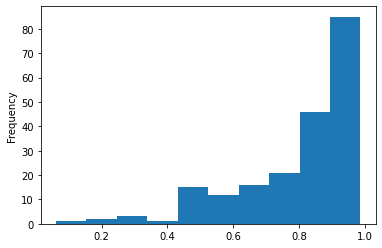

In [15]:
df['valence'].plot.hist()

In [16]:
df[df['valence'] < 0.2]

,id,name,artist_id,artist_name,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
76,4K8VrFYg7q992yodbqZamF,Hale Bopp - Maceo Plex Edit,5RZGHff3PE1rPUKOpDIqaO,Der Dritte Raum,36,0.806,0.974,4,-6.933,0,0.0457,0.02430,0.869,0.0927,0.1570,125.004,439000,4
88,3NTgbMDEQ8UOdi3nxQBcoh,Cum 2Geza - Original Mix,7IgApBf9ibPRfKv28sy7Dh,RareTwo Inc.,46,0.813,0.718,9,-7.452,0,0.0502,0.00171,0.549,0.1310,0.0611,126.001,411429,4


<img src="bpm_pace.png" width="600">

In [19]:
# set the BPM range
tempo_min, tempo_max = 120, 130
track_ids = list(df[(df['tempo'] >= tempo_min) & (df['tempo'] <= tempo_max) & (df['danceability'] >= 0.5)]['id'])
len(track_ids)

50

In [20]:
playlist_id, is_new = spotify.get_playlist_by_name(sp, 
        f"Run Test BPM {tempo_min} - {tempo_max}", 
        create_if_none=True)
if playlist_id and is_new:
    print(f"Created new playlist with ID {playlist_id}")
elif playlist_id:
    print(f"Found existing playlist with ID {playlist_id}")
else:
    print("Something went wrong :-(")

Created new playlist with ID 1BfmdmBfylz9Xb9vo7FDNS


In [21]:
num_tracks_added = spotify.add_tracks(sp, playlist_id, track_ids)
num_tracks_added

50

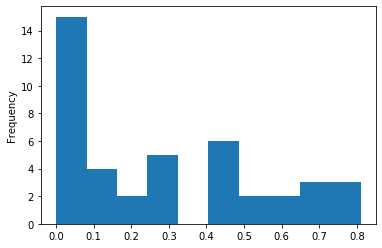

In [7]:
df['acousticness'].plot.hist()

# Get all my public playlists

In [7]:
sp_response = sp.current_user_playlists()
all_playlists = sp_response['items']
while sp_response['next']:
    sp_response = sp.next(sp_response)
    all_playlists.extend(sp_response['items'])
len(all_playlists)

73

In [8]:
own_playlists = list(filter(lambda l: l['owner']['id'] == user['id'], all_playlists))
len(own_playlists)

49

In [9]:
own_playlists_trimmed = [{k: v for k, v in d.items() if k in ['id', 'name', 'public', 'tracks']} for d in own_playlists]
len(own_playlists_trimmed)

49

In [10]:
public_playlists = list(filter(lambda l: (l['public'] == True), own_playlists_trimmed))
len(public_playlists)

17

In [11]:
public_playlists

[{'id': '6u5RL72VpPaJfeLksVLE2Q',
  'name': 'Mellow Jazz',
  'public': True,
  'tracks': {'href': 'https://api.spotify.com/v1/playlists/6u5RL72VpPaJfeLksVLE2Q/tracks',
   'total': 712}},
 {'id': '7JYdgqlBBhiCqjpx2pVKwf',
  'name': 'KJAH',
  'public': True,
  'tracks': {'href': 'https://api.spotify.com/v1/playlists/7JYdgqlBBhiCqjpx2pVKwf/tracks',
   'total': 1610}},
 {'id': '4jdHBhEw9a9OBJ0CVbmpFX',
  'name': 'Run',
  'public': True,
  'tracks': {'href': 'https://api.spotify.com/v1/playlists/4jdHBhEw9a9OBJ0CVbmpFX/tracks',
   'total': 68}},
 {'id': '2MzQi9D9OtFuUsuOS8lwtS',
  'name': 'Power Songs',
  'public': True,
  'tracks': {'href': 'https://api.spotify.com/v1/playlists/2MzQi9D9OtFuUsuOS8lwtS/tracks',
   'total': 925}},
 {'id': '5ngdqzXvg3v6yakZ6oAcxv',
  'name': 'Trojan Archives',
  'public': True,
  'tracks': {'href': 'https://api.spotify.com/v1/playlists/5ngdqzXvg3v6yakZ6oAcxv/tracks',
   'total': 749}},
 {'id': '566s1zzyRtF4bzv9JfpnVY',
  'name': 'Pop2000',
  'public': True,
  '